In [6]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import pickle as pkl
from dateutil import parser
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import Levenshtein
from wordcloud import STOPWORDS
from unidecode import unidecode
import unicodedata
from omnibelt import load_json, save_json

In [2]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [3]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		if desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))
def str_similarity(string1: str, string2: str):
	distance = Levenshtein.distance(string1, string2)
	similarity = 1 - (distance / max(len(string1), len(string2)))
	return similarity
def capsim(s1, s2):
	s1, s2 = unidecode(s1), unidecode(s2)
	return (str_similarity(s1.lower(), s2.lower()) + str_similarity(s1, s2)) / 2
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
stop_words = set(STOPWORDS)
def is_good_word(w):
	return not all(unicodedata.category(char).startswith('P') or unicodedata.category(char).startswith('N') for char in w) and w not in stop_words

In [4]:
root = Path('/home/fleeb/workspace/local_data/nnn')
root = Path(r'C:\Users\anwan\Documents\workspace\nnn')
recs = (root / 'old-bb-v1').glob('**/*.json')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
temproot = root/'temp'
temproot.mkdir(exist_ok=True)
recs = list(recs)
len(recs)

54

In [12]:
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [13]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [16]:
batch = by_lang['de']
len(batch)

259718

In [17]:
art = random.choice(batch)
view_article(art, detailed=True)
print(art['source-name'])

English Title: 'Substitution Luca Mack - VfB Stuttgart'
German Title: 'Wechsel Luca Mack - VfB Stuttgart'
Categories: <sports>  ---   'Germany' (08 Aug21)  ---  Www.vfb.de
English Description: After nine years in the VfB jersey, Luca Mack is moving to the Hungarian first division club Ujpest Budapest.
German Description: Nach neun Jahren im VfB-Trikot wechselt Luca Mack zum ungarischen Erstligisten Ujpest Budapest.
Www.vfb.de


In [9]:
# lowercase_all = True
# full_bagowords_inds = {int(ID): {k.lower() if lowercase_all else k:v for k,v in bag.items()} 
# 					   for ID, bag in tqdm(load_json(root/'bagowords-ordered-full.json').items())}
# 
# pre_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items()):
# 	if '-' in bagi:
# 		pre_dash.update({w: len(inds) for w, inds in bagi.items() if all(i < bagi["-"][-1] for i in inds)})
# 
# post_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items()):
# 	if '-' in bagi:
# 		post_dash.update({w: len(inds) for w, inds in bagi.items() if w not in pre_dash})
# all_bags_inds = {ID: {w: [i for i in inds if bag.get('-', [float('inf')])[-1] > i]
# 					  for w, inds in bag.items() if w not in post_dash and is_good_word(w)}
# 				 for ID, bag in tqdm(full_bagowords_inds.items())}
# all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds)}) for ID, bag in all_bags_inds.items()}
# len(all_bags)
# save_json(all_bags, temproot/'all_bags.json')
# save_json(all_bags_inds, temproot/'all_bags_inds.json')
# all_bags_inds = pkl.load(open(root/'temp'/'all_bags_inds.pkl', 'rb'))
# all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds) and is_good_word(w)}) for ID, bag in all_bags_inds.items()}
# world = articles
# df = pd.DataFrame(
# 	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in world]) for i, inst in
# 	 enumerate(by_ID[row['aid']]['instances'])])
# df['collectedAt'] = pd.to_datetime(df['collectedAt'])
# df = df.sort_values('collectedAt')
# df['date'] = df['collectedAt'].dt.date
# len(df)
# 
# daybags = {}
# date_aids = dict(df.groupby('date')['aid'].apply(set))
# for date, aIDs in tqdm(sorted(date_aids.items())):
# 	total = Counter()
# 	for aID in aIDs:
# 		total.update(all_bags[aID])
# 	daybags[date] = total
# len(daybags)
# dayidf = Counter()
# for date, bag in tqdm(daybags.items()):
# 	dayidf.update(bag.keys())
# dayidf = {w: np.log(len(daybags) / f) for w, f in dayidf.items()}
# daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
# daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in
# 			tqdm(daybags.items())}
# len(daytfidf)

4719199

In [5]:
use_bags_as_sets = True
all_bags = load_json(temproot/'all_bags.json')
# all_bags_inds = load_json(temproot/'all_bags_inds.json')
all_bags = {int(ID): set(bag) if use_bags_as_sets else bag for ID, bag in all_bags.items()}
# pkl.dump(date_aids, open(temproot/'date_aids.pkl', 'wb'))
date_aids = pkl.load(open(temproot/'date_aids.pkl', 'rb'))
daytfidf = pkl.load(open(temproot/'daytfidf.pkl', 'rb'))
daybags = {}
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags), len(all_bags)#, len(all_bags_inds)

In [281]:
def cluster_min_agreement(bag, aids, match_req=.5):
	total = sum(bag.values())
	matches, remaining = [], []
	for aid in aids:
		(matches if sum(bag.get(w,0) for w in all_bags[aid]) / total >= match_req else remaining).append(aid)
		# (matches if len(bag & all_bags[aid]) >= max(1, min(len(bag), len(all_bags[aid]), match_req)) else remaining).append(aid)
	return matches, remaining

def date_freq(today, topk=5, before=20, after=20, match_req=.5):
	mindate = today - pd.Timedelta(days=before)
	maxdate = today + pd.Timedelta(days=after)
	daterange = [d for d in daytfidf if mindate <= d <= maxdate]
	deltas = [(d - today).days for d in daterange]
	importances = daytfidf[today]
	scores = Counter({aid: sum(importances.get(w, 0) for w in all_bags[aid]) for aid in date_aids[today]})
	
	keydocs = {}
	
	todo = list(date_aids[today])
	for k in tqdm(range(topk)):
		center = max(todo, key=lambda aid: scores[aid])
		# print(center, ', '.join(f'{w!r}' for w in sorted(all_bags[center], key=lambda w: importances.get(w,0), reverse=True)[:8]))
		cluster = {w: importances[w] for w in all_bags[center]}
		todo.remove(center)
		matches = {}
		for i in range(len(deltas)):
			delta = deltas[i]
			matches[delta], other = cluster_min_agreement(cluster, todo if delta == 0 else date_aids[daterange[i]], match_req=match_req)
			if delta == 0:
				todo = other
				matches[delta].append(center)
		keydocs[center] = matches
	return keydocs

In [295]:
start, end = datetime(2020, 10, 3).date(), datetime(2021, 10, 3).date()
lowlimit, highlimit = min(daytfidf), max(daytfidf)
start in daytfidf, end in daytfidf

(True, True)

In [346]:
target = random.choice(list(daytfidf.keys()))
target = random.choice([d for d in daytfidf if start <= d <= end])
# target = datetime(2021, 2, 1).date()
# target = datetime(2021, 1, 8).date()
importances = daytfidf[target]
counts = daybags[target]
def compute_article_score(aid):
	return sum(importances.get(w, 0) for w in all_bags[aid])
scores = Counter({aid: compute_article_score(aid) for aid in date_aids[target]})
print(target.strftime('%d %b %Y'))
offset = (target - start).days
offset = 0
# offset

27 Sep 2021


In [347]:
top = {}
todo = list(scores.keys())
intial_num = len(todo)
# day_delta = 40
day_before = 30
day_after = 30

topk = 10
match_threshold = 0.25

In [348]:
for _ in range(10):
	center = max(todo, key=lambda aid: scores[aid])
	cluster = {w: importances[w] for w in all_bags[center]}
	todo.remove(center)
	matches, todo = cluster_min_agreement(cluster, todo, match_req=match_threshold)
	top[center] = matches
# len(matches), len(todo)
print(tabulate([(
	aid, 
	# scores[aid], 
	len(matches), 
	', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8]) + (f' + {len(all_bags[aid])-8} more' if len(all_bags[aid]) > 8 else ''), 
	# len(all_bags[aid])
) for aid, matches in sorted(top.items(), key=lambda item: scores[item[0]], reverse=True)]))
print(f'{intial_num-len(todo)} / {intial_num}   ---   {(intial_num-len(todo))/intial_num:.2%} for {len(top)} clusters')

-------  --  -----------------------------------------------------------------------------------------------
6622611  11  'tudum', 'sandman', 'bebop', 'things', 'cowboy', 'stranger', 'rewatch', 'peek' + 2 more
6627984  26  'laver', 'rublev', 'zverev', 'devastating', 'victory', 'europe', 'complete', 'cup'
6634194  23  'civi', '32mp', 'amoled', '120hz', 'xiaomi', 'camera', 'snapdragon', 'g' + 3 more
6634982  17  'goxx', 'hamster', 'tradet', 'besser', 'buffet', 'krypto', 'warren', 'mr.' + 1 more
6631007  42  'ryder', 'felton', 'mend', 'potter', 'tom', 'harry', 'collapse', 'cup' + 2 more
6625294  21  'lancaster', 'quo', 'bassist', 'alan', 'founding', 'member', 'status', 'die'
6630563  12  'dunham', 'felber', 'lena', 'marries', 'luis', 'ceremony', 'boyfriend', 'secret'
6595490  26  'palma', 'vieja', 'cumbre', 'volcano', 'eruption', 'anguish', 'endless', 'science' + 6 more
6624647   9  'petito', 'laundrie', 'gabby', 'bounty', 'appa', 'brian', 'vow', 'boyfriend' + 7 more
6623127  63  'evergra

In [349]:
grand, matches = max(top.items(), key=lambda item: scores[item[0]])
print(tabulate([[i, aid, ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8]) + (f' + {len(all_bags[aid])-8} more' if len(all_bags[aid]) > 8 else '')]
				for i, aid in enumerate(matches)]))

--  -------  ---------------------------------------------------------------------------------------------
 0  6622424  'tudum', 'stranger', 'teaser', 'season', 'netflix', 'event', 'drop', 'thing' + 1 more
 1  6622619  'tudum', 'rebelde', 'cobra', 'kai', 'netflix', 'surprise', 'crown'
 2  6623002  'tudum', 'fans', 'netflix', 'event', 'leave', 'global', 'announcement'
 3  6625681  'tudum', 'stranger', 'bridgertons', 'chronicle', 'netflix', 'event', 'crown', 'sex' + 4 more
 4  6628703  'tudum', 'sandman', 'things', 'stranger', 'cbr', 'trailer', 'netflix', "'s" + 1 more
 5  6629742  'tudum', 'things', 'stranger', 'trailer', 'netflix', 'new', 'present'
 6  6629834  'tudum', 'netflix', 'screen', "'s", 'tv', 'show', 'big', '|' + 1 more
 7  6630827  'tudum', 'trailer', 'activity', 'netflix', 'movie', 'surprise', 'full', 'collection' + 4 more
 8  6630863  'tudum', 'trailer', 'activity', 'netflix', 'movie', 'surprise', 'full', 'collection' + 4 more
 9  6634166  'tudum', 'witcher', 'bridgerton',

In [350]:
keydocs = date_freq(target, topk=topk, before=day_before, after=day_after, match_req=match_threshold)
print(tabulate([(
	len(all_bags[aid]), 
	aid,
				 sum(len(m) for d, m in matches.items() if d < 0), 
				 sum(len(m) for d, m in matches.items() if d == 0), 
				 sum(len(m) for d, m in matches.items() if d > 0), 
				 ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8])
				 ) for aid, matches in keydocs.items()]))
len(keydocs)

  0%|          | 0/10 [00:00<?, ?it/s]

--  -------  ---  --  ---  -------------------------------------------------------------------------------------
10  6622611   23  12    5  'tudum', 'sandman', 'bebop', 'things', 'cowboy', 'stranger', 'rewatch', 'peek'
 8  6627984   62  27   23  'laver', 'rublev', 'zverev', 'devastating', 'victory', 'europe', 'complete', 'cup'
11  6634194   75  24   98  'civi', '32mp', 'amoled', '120hz', 'xiaomi', 'camera', 'snapdragon', 'g'
 9  6634982   13  18   84  'goxx', 'hamster', 'tradet', 'besser', 'buffet', 'krypto', 'warren', 'mr.'
10  6631007  238  43   60  'ryder', 'felton', 'mend', 'potter', 'tom', 'harry', 'collapse', 'cup'
 8  6625294   25  22   54  'lancaster', 'quo', 'bassist', 'alan', 'founding', 'member', 'status', 'die'
 8  6630563    1  13   24  'dunham', 'felber', 'lena', 'marries', 'luis', 'ceremony', 'boyfriend', 'secret'
14  6595490  134  27  302  'palma', 'vieja', 'cumbre', 'volcano', 'eruption', 'anguish', 'endless', 'science'
15  6624647  105  10   62  'petito', 'laundrie', 

10

In [351]:
import numpy as np
from scipy.interpolate import interp1d

In [352]:
best = {center: matches for center, matches in keydocs.items() if len(matches[0]) == max(map(len,matches.values()))}
print(tabulate([(
	len(all_bags[aid]), 
	aid,
				 sum(len(m) for d, m in matches.items() if d < 0), 
				 sum(len(m) for d, m in matches.items() if d == 0), 
				 sum(len(m) for d, m in matches.items() if d > 0), 
				 ', '.join(f'{w!r}' for w in sorted(all_bags[aid], key=lambda w: importances.get(w,0), reverse=True)[:8])
				 ) for aid, matches in best.items()]))

-  -------  --  --  --  ----------------------------------------------------------------------------------
8  6627984  62  27  23  'laver', 'rublev', 'zverev', 'devastating', 'victory', 'europe', 'complete', 'cup'
8  6625294  25  22  54  'lancaster', 'quo', 'bassist', 'alan', 'founding', 'member', 'status', 'die'
8  6630563   1  13  24  'dunham', 'felber', 'lena', 'marries', 'luis', 'ceremony', 'boyfriend', 'secret'
-  -------  --  --  --  ----------------------------------------------------------------------------------


In [353]:
X = np.arange(-day_before, day_after+1)
Ys = []
for center, matches in sorted(best.items(), key=lambda item: sum(map(len,item[1].values())), reverse=False):
	x, y = zip(*[(d+offset, len(m)) for d, m in matches.items()])
	interp_func = interp1d(x, y, kind='quadratic', fill_value="extrapolate")
	Ys.append(np.clip(interp_func(X),0,None))
Ys = np.array(Ys).T
X += offset
X.shape, Ys.shape

((61,), (61, 3))

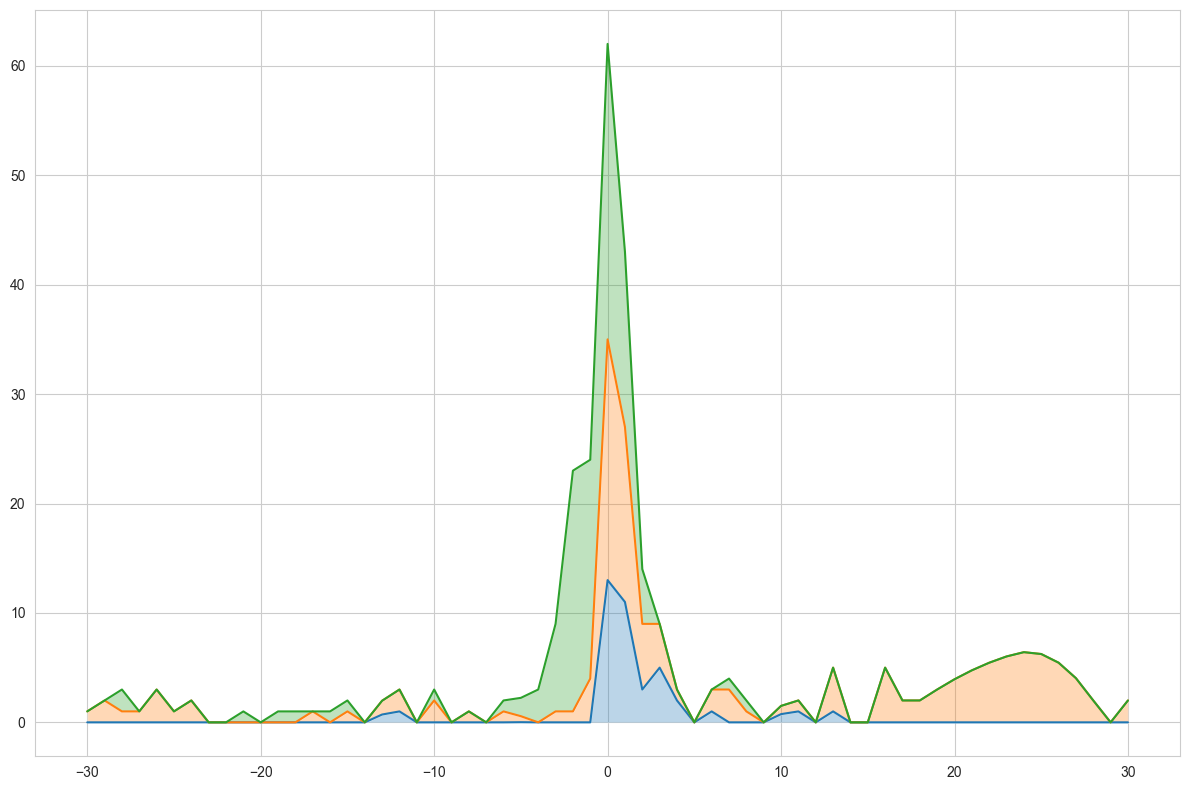

In [354]:
plt.figure(figsize=(12,8))

cYs = Ys.cumsum(-1)

Y = cYs
# Y = Ys

plt.plot(X, Y);

lb = 0
for i in range(Y.shape[1]):
	plt.fill_between(X, lb, Y[:, i], alpha=.3)
	lb = Y[:, i]

# plt.ylim(0, 400);
# plt.xlim(0, 300);
# plt.plot(X, Ys, label=f'{center}');
plt.tight_layout();

In [60]:
todo = list(scores.keys())

In [61]:
center = max(todo, key=lambda aid: scores[aid])
cluster = set(all_bags[center])
todo.remove(center)
print(center, ', '.join(f'{w!r}' for w in sorted(all_bags[center], key=lambda w: importances.get(w,0), reverse=True)[:8]))
matches, todo = cluster_min_agreement(all_bags[center], todo)
len(matches), len(todo)

5874414 'kipchoge', 'eliud', 'medal', 'olympics', 'marathon', 'win', 'tokyo', 'gold'


In [52]:
cluster

{'eliud', 'gold', 'kipchoge', 'marathon', 'medal', 'olympics', 'tokyo', 'win'}

In [53]:
len(todo)

14827

(True, True)